In [27]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import io
import os
import re
import string
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (
  Embedding,Input,LSTM,Input,Conv2D,Softmax,Dropout,Dense,GRU,
  MaxPooling2D,LayerNormalization,Reshape,BatchNormalization,Bidirectional)
from tensorflow.keras.optimizers import Adam

In [28]:
print('Tensorflow => ',tf.__version__)
print('Keras      => ',tf.keras.__version__)
print('Numpy      => ',np.__version__)

Tensorflow =>  2.10.0
Keras      =>  2.10.0
Numpy      =>  1.25.2


In [29]:
gpus = tf.config.list_physical_devices('GPU')
gpus[0]
tf.config.experimental.set_memory_growth(gpus[0], True)

In [30]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
#import requests
from keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.compat.v1.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
BATCH_SIZE=8
LR=1e-4
FRAME_LENGTH=255
FRAME_STEP=128
N_EPOCHS=100

# Noisy Data

## Data Visualization

In [32]:
audio_binary=tf.io.read_file("D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav/p226_016.wav")
audio,_=tf.audio.decode_wav(audio_binary)
waveform=tf.squeeze(audio,axis=-1)
waveform=tf.cast(waveform,tf.float32)
signal=waveform
print(signal.shape)

(372000,)


(372000,)


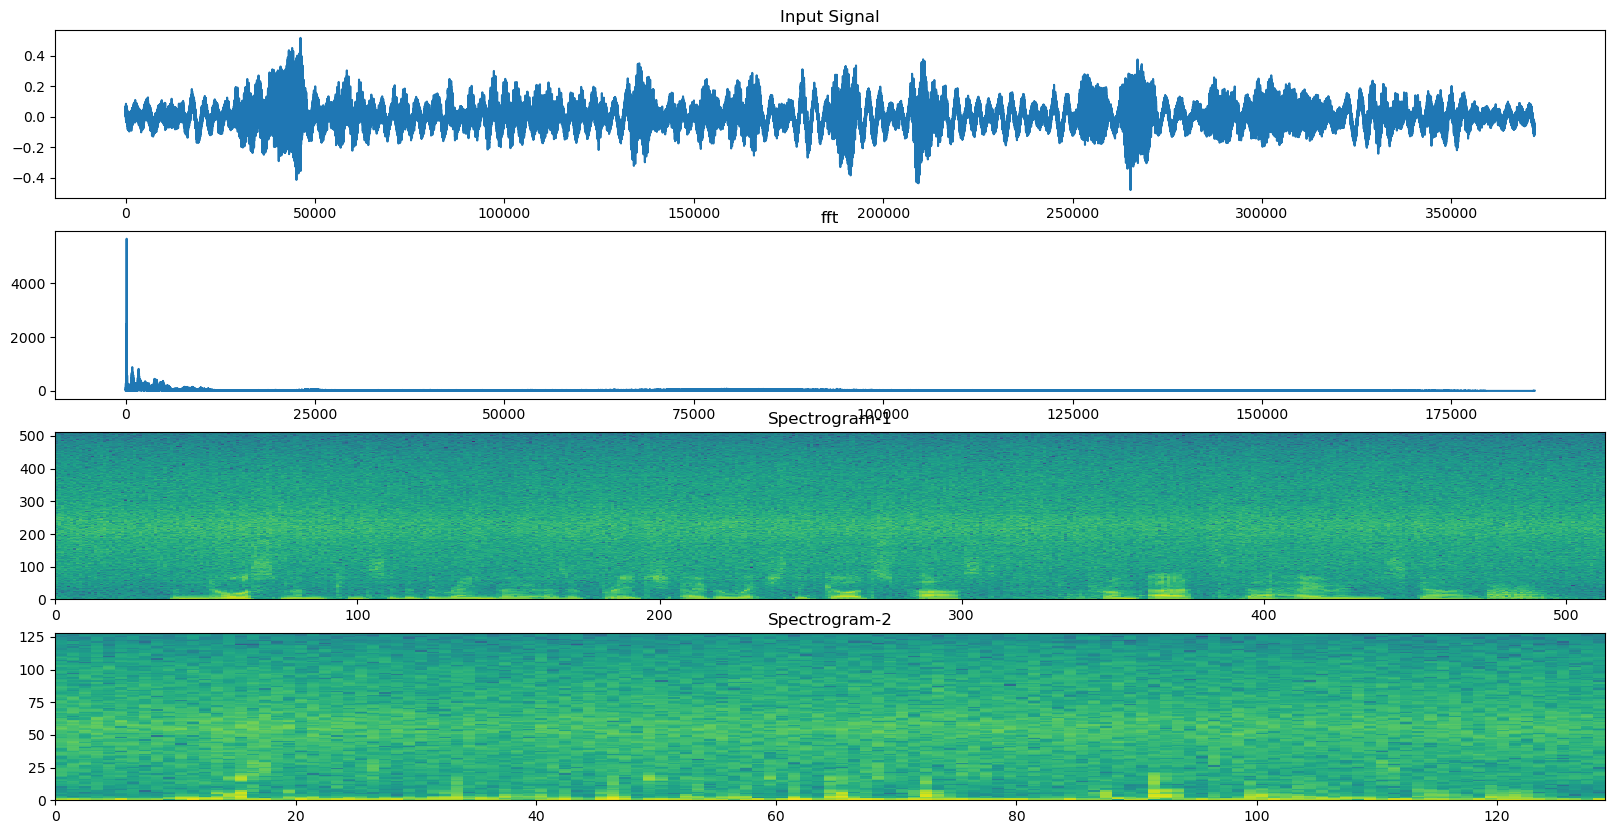

In [33]:
fig,axis=plt.subplots(4,figsize=(20,10))

L=2000
x=tf.linspace(-L//2,L//2,L)
print(signal.shape)
axis[0].plot(signal)
axis[0].set_title("Input Signal")

fft=tf.signal.rfft(signal)

axis[1].plot(tf.abs(fft))
axis[1].set_title("fft")


spec=tf.signal.stft(signal,frame_length=1024,frame_step=512,)
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[2].pcolormesh(X,Y,power_spec)
axis[2].set_title("Spectrogram-1")


spec=tf.signal.stft(signal,frame_length=256,frame_step=128, )
spec=tf.transpose(tf.abs(spec),[1,0])

power_spec=np.log(spec)
height=power_spec.shape[0]

width=power_spec.shape[1]

X=np.linspace(0,power_spec.shape[0],num=width,dtype=int)
Y=range(height)

axis[3].pcolormesh(X,Y,power_spec)
axis[3].set_title("Spectrogram-2")


plt.show()


In [34]:
Y

range(0, 129)

In [35]:
X

array([  0,   0,   0, ..., 128, 128, 129])

## Data Preparation

In [72]:
#not working
import tensorflow_io as tfio

def reSample(file) :
  rateOut=16000  
  audioIOTensor = tfio.audio.AudioIOTensor(file)  
  print(audioIOTensor.shape)
  chanalsIn=(int)(audioIOTensor.shape[1])
  rateIn=(int)(audioIOTensor.rate)
  print(audioIOTensor.shape[1])
  audioTensor = audioIOTensor[0:] #get audio block  

  if (chanalsIn>1): #sterio to mono
    audioTensor=audioTensor.numpy()
    audioTensor=np.average(audioTensor,axis=1)
    audio_slice=tf.convert_to_tensor(audioTensor)

  print(audioTensor.shape)

  #change rate
  audioTensor=tfio.audio.resample(audioTensor, rateIn,rateOut)

  print(audioTensor.shape)


  # remove last dimension
  #audioTensor = tf.squeeze(audioTensor, axis=[1])
  # convert to wav and save 
  #wav = tf.cast(audioTensor, tf.float32) / 32768.0
  print(audioTensor.shape)
  audioTensor=tf.expand_dims(audioTensor, axis=1)  # add axis for tf.audio.encode_wav
  print(audioTensor.shape)
  outWavAudio=tf.audio.encode_wav(audio=audioTensor,sample_rate=rateOut)
      
  tf.io.write_file(file,outWavAudio)

In [63]:
from pydub import AudioSegment as am
def reSample2(filePath) :
    sound = am.from_file(filePath, format='wav', frame_rate=getSamplingRate(filePath))
    sound = sound.set_frame_rate(16000)
    sound.export(filePath, format='wav')

In [56]:
path1="D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav"
dir_list1 = os.listdir(path1)
dir_list1

['p226_001.wav',
 'p226_002.wav',
 'p226_003.wav',
 'p226_004.wav',
 'p226_005.wav',
 'p226_006.wav',
 'p226_007.wav',
 'p226_008.wav',
 'p226_009.wav',
 'p226_010.wav',
 'p226_011.wav',
 'p226_012.wav',
 'p226_013.wav',
 'p226_014.wav',
 'p226_015.wav',
 'p226_016.wav',
 'p226_017.wav',
 'p226_018.wav',
 'p226_019.wav',
 'p226_020.wav',
 'p226_021.wav',
 'p226_022.wav',
 'p226_023.wav',
 'p226_024.wav',
 'p226_025.wav',
 'p226_026.wav',
 'p226_027.wav',
 'p226_028.wav',
 'p226_029.wav',
 'p226_030.wav',
 'p226_031.wav',
 'p226_032.wav',
 'p226_033.wav',
 'p226_034.wav',
 'p226_036.wav',
 'p226_037.wav',
 'p226_039.wav',
 'p226_040.wav',
 'p226_041.wav',
 'p226_042.wav',
 'p226_043.wav',
 'p226_044.wav',
 'p226_045.wav',
 'p226_046.wav',
 'p226_047.wav',
 'p226_048.wav',
 'p226_049.wav',
 'p226_050.wav',
 'p226_051.wav',
 'p226_052.wav',
 'p226_053.wav',
 'p226_054.wav',
 'p226_055.wav',
 'p226_056.wav',
 'p226_057.wav',
 'p226_058.wav',
 'p226_059.wav',
 'p226_060.wav',
 'p226_061.wav

In [62]:
for wavFile in dir_list1:  
    reSample2("D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav/"+wavFile)

In [64]:
audio_text2={}
path="D:/CDAC/Datasets/DenoisingAudioCollection/trainset_28spk_txt/trainset_28spk_txt"
dir_list = os.listdir(path)
dir_list


['p226_001.txt',
 'p226_002.txt',
 'p226_003.txt',
 'p226_004.txt',
 'p226_005.txt',
 'p226_006.txt',
 'p226_007.txt',
 'p226_008.txt',
 'p226_009.txt',
 'p226_010.txt',
 'p226_011.txt',
 'p226_012.txt',
 'p226_013.txt',
 'p226_014.txt',
 'p226_015.txt',
 'p226_016.txt',
 'p226_017.txt',
 'p226_018.txt',
 'p226_019.txt',
 'p226_020.txt',
 'p226_021.txt',
 'p226_022.txt',
 'p226_023.txt',
 'p226_024.txt',
 'p226_025.txt',
 'p226_026.txt',
 'p226_027.txt',
 'p226_028.txt',
 'p226_029.txt',
 'p226_030.txt',
 'p226_031.txt',
 'p226_032.txt',
 'p226_033.txt',
 'p226_034.txt',
 'p226_036.txt',
 'p226_037.txt',
 'p226_039.txt',
 'p226_040.txt',
 'p226_041.txt',
 'p226_042.txt',
 'p226_043.txt',
 'p226_044.txt',
 'p226_045.txt',
 'p226_046.txt',
 'p226_047.txt',
 'p226_048.txt',
 'p226_049.txt',
 'p226_050.txt',
 'p226_051.txt',
 'p226_052.txt',
 'p226_053.txt',
 'p226_054.txt',
 'p226_055.txt',
 'p226_056.txt',
 'p226_057.txt',
 'p226_058.txt',
 'p226_059.txt',
 'p226_060.txt',
 'p226_061.txt

In [65]:
for file in dir_list:  
  i=str(file)
  i=i.replace(".txt","")  
  with open(path+'/'+file, encoding="utf-8") as f:    
    text=f.readline().removesuffix("/n")
    text=text.replace(".   ",".")
    text=text.replace(".  ",".")
    text=text.replace(". ",".")
    audio_text2[str(i)]=text
  f.close

audio_text2

{'p226_001': 'Please call Stella.\n',
 'p226_002': 'Ask her to bring these things with her from the store.\n',
 'p226_003': 'Six spoons of fresh snow peas, five thick slabs of blue cheese, and maybe a snack for her brother Bob.\n',
 'p226_004': 'We also need a small plastic snake and a big toy frog for the kids.\n',
 'p226_005': 'She can scoop these things into three red bags, and we will go meet her Wednesday at the train station.\n',
 'p226_006': 'When the sunlight strikes raindrops in the air, they act as a prism and form a rainbow.\n',
 'p226_007': 'The rainbow is a division of white light into many beautiful colors.\n',
 'p226_008': 'These take the shape of a long round arch, with its path high above, and its two ends apparently beyond the horizon.\n',
 'p226_009': 'There is , according to legend, a boiling pot of gold at one end.\n',
 'p226_010': 'People look, but no one ever finds it.\n',
 'p226_011': 'When a man looks for something beyond his reach, his friends say he is lookin

In [66]:
filepaths=["D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav/"+filename+".wav" for filename in list(audio_text2.keys())]
transcriptions=[audio_text2[str(filename)].lower() for filename in list(audio_text2.keys())]
print(len(filepaths))
print(len(transcriptions))

11572
11572


In [67]:
dataset=tf.data.Dataset.from_tensor_slices((filepaths,transcriptions))

for i in dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav/p226_001.wav'>, <tf.Tensor: shape=(), dtype=string, numpy=b'please call stella.\n'>)


In [68]:
def decode_audio(audio_binary):
    audio,_=tf.audio.decode_wav(audio_binary)    
    return tf.squeeze(audio,axis=-1)

In [69]:
vocabulary=[""]+[chr(i) for i in range(97,97+26)]+[".",",","?"," "]
print(vocabulary)
print(len(vocabulary))

['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.', ',', '?', ' ']
31


In [70]:
def get_label(label,):
    label=tf.strings.unicode_split(label, input_encoding="UTF-8")
    label=tf.keras.layers.StringLookup(vocabulary=vocabulary, oov_token="")(label)
    return label

In [71]:
from scipy.io.wavfile import read as read_wav
import os
#os.chdir('path') # change to the file directory

def getSamplingRate(filePath):
    sampling_rate, data=read_wav(filePath) # enter your filename
    return sampling_rate

In [73]:
def get_spec(filepath,label):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
  waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)
  spectrogram=tf.abs(spectrogram)
  label=get_label(label)
  return tf.expand_dims(spectrogram,axis=-1),label

In [74]:
processed_dataset = (
    dataset.map(get_spec, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [75]:
train_dataset=processed_dataset.take(int(0.95*len(processed_dataset)))
val_dataset=processed_dataset.skip(int(0.95*len(processed_dataset)))

In [76]:
for i,j in train_dataset.take(1):
  print(i,j)

tf.Tensor(
[[[[4.7265664e-02]
   [8.4663361e-02]
   [1.4947011e-01]
   ...
   [5.8422182e-03]
   [3.0521005e-03]
   [4.4396501e-03]]

  [[6.5703177e-01]
   [4.6754909e-01]
   [1.0497421e-01]
   ...
   [9.1295661e-03]
   [7.5086649e-03]
   [2.7132034e-03]]

  [[7.5588101e-01]
   [4.0829730e-01]
   [1.8601172e-01]
   ...
   [5.9700496e-03]
   [7.7490560e-03]
   [9.4150901e-03]]

  ...

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]

  [[0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]
   ...
   [0.0000000e+00]
   [0.0000000e+00]
   [0.0000000e+00]]]


 [[[1.0941255e-01]
   [1.3320017e-01]
   [4.2169519e-02]
   ...
   [3.2318118e-03]
   [8.8558160e-04]
   [2.6386678e-03]]

  [[3.8955212e-01]
   [2.2898656e-01]
   [4.9016174e-02]
   ...
   [5.9371581e-03]
   [2.6483049e-03]
   [7.2251260e-04

## Modeling 

In [77]:
normalization=tf.keras.layers.Normalization()

In [78]:
input_spectrogram=Input((None,129,1), name="input")

x=normalization(input_spectrogram)
x=Conv2D(32,kernel_size=[11,41],strides=[2,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)
x=Conv2D(64,kernel_size=[11,21],strides=[1,2],padding='same',activation='relu')(x)
x=LayerNormalization()(x)

x=Reshape((-1, x.shape[-2] * x.shape[-1]))(x)

x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)
x=Bidirectional(GRU(128,return_sequences=True))(x)


output=Dense(len(vocabulary)+1, activation="softmax")(x)

model = tf.keras.Model(input_spectrogram, output, name="DeepSpeech_2_Inspired")
model.summary()

Model: "DeepSpeech_2_Inspired"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 129, 1)]    0         
                                                                 
 normalization (Normalizatio  (None, None, 129, 1)     3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, None, 65, 32)      14464     
                                                                 
 layer_normalization (LayerN  (None, None, 65, 32)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, None, 33, 64)      473152    
                                                                 
 layer_normalization_1 (Laye  (None, None, 33

In [79]:
def ctc_loss(y_true,y_pred):
  batch_size=tf.shape(y_pred)[0]
  pred_length=tf.shape(y_pred)[1]
  true_length=tf.shape(y_true)[1]

  pred_length=pred_length*tf.ones([batch_size,1],dtype=tf.int32)
  true_length=true_length*tf.ones([batch_size,1],dtype=tf.int32)

  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,pred_length,true_length)

In [80]:
model.compile(
    loss=ctc_loss,
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
)

In [81]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ASR_Noisy_28spk_Model-{epoch:03d}.h5")
model_path='D:/CDAC/Project/ASR-using-deepspeech2/ASR_Noisy_28spk_Model_Final.h5'

## Training

In [82]:
history=model.fit(
  train_dataset,
  validation_data=val_dataset,
  verbose=1,
  epochs=N_EPOCHS,  
  callbacks=[checkpoint_cb]  
)

Epoch 1/100
1374/1374 [==============================] - 377s 267ms/step - loss: 125.5759 - val_loss: 110.1150
Epoch 2/100
1374/1374 [==============================] - 225s 163ms/step - loss: 119.2850 - val_loss: 108.8914
Epoch 3/100
1374/1374 [==============================] - 227s 165ms/step - loss: 117.9708 - val_loss: 107.8176
Epoch 4/100
1374/1374 [==============================] - 231s 168ms/step - loss: 116.3107 - val_loss: 103.7068
Epoch 5/100
1374/1374 [==============================] - 233s 170ms/step - loss: 110.6489 - val_loss: 100.4138
Epoch 6/100
1374/1374 [==============================] - 237s 172ms/step - loss: 108.3505 - val_loss: 99.4997
Epoch 7/100
1374/1374 [==============================] - 231s 168ms/step - loss: 106.8421 - val_loss: 97.7678
Epoch 8/100
1374/1374 [==============================] - 228s 166ms/step - loss: 105.5722 - val_loss: 96.9031
Epoch 9/100
1374/1374 [==============================] - 226s 165ms/step - loss: 104.5675 - val_loss: 96.1391
Epoch

In [83]:
# save model
model.save(model_path)

## Testing

In [84]:
model.load_weights('D:/CDAC/Project/ASR-using-deepspeech2/ASR_Noisy_28spk_Model_Final.h5')

In [85]:
#obtain and decode the acoustic model's predictions
model.load_weights(model_path)

In [86]:
def get_spec_inference(filepath):

  audio_binary=tf.io.read_file(filepath)
  waveform=decode_audio(audio_binary)
  waveform=tf.cast(waveform,tf.float32)

  spectrogram=tf.signal.stft(
      waveform,frame_length=FRAME_LENGTH,frame_step=FRAME_STEP)

  spectrogram=tf.abs(spectrogram)

  return tf.expand_dims(spectrogram,axis=-1)

In [87]:
def decode(y_pred):
  batch_size=tf.shape(y_pred)[0]
  print(tf.shape(y_pred))

  pred_length=tf.shape(y_pred)[1]
  pred_length*=tf.ones([batch_size,],dtype=tf.int32)

  y_pred=tf.one_hot(y_pred,len(vocabulary)+1)
  output=tf.keras.backend.ctc_decode(y_pred,input_length=pred_length,greedy=True)[0][0]

  out=[vocabulary[i] for i in output[0]]
  return ''.join(out)

In [104]:
test_path="D:/CDAC/Datasets/DenoisingAudioCollection/noisy_trainset_28spk_wav/noisy_trainset_28spk_wav/p226_056.wav"
from IPython.display import Audio
# play the audio file
Audio(test_path)

In [105]:
getSamplingRate(test_path)

16000

In [106]:
spectrogram=get_spec_inference(test_path)
print(spectrogram.shape)
out=tf.argmax(model.predict(tf.expand_dims(spectrogram,axis=0))[0],axis=1)
out

(387, 129, 1)
1/1 [==============================] - 0s 118ms/step


<tf.Tensor: shape=(194,), dtype=int64, numpy=
array([ 6, 31, 15, 18, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 30, 20,  8,  5, 31, 31, 30, 30, 13, 31,  5,
       31, 31, 31,  1,  1, 31, 31, 31, 20, 31,  9, 13, 13, 31, 31, 31, 31,
       31, 31, 31,  5, 28, 30, 30, 20,  8,  1, 21, 31, 31, 31, 31, 31, 31,
       31, 31,  8,  8,  8, 28, 28, 28, 30, 20,  8,  5, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 30, 30, 19, 19, 31,  9, 14, 31, 31,
       31, 31,  7, 31, 31, 31, 31, 31, 19, 19, 30, 30, 31, 31,  1, 18, 31,
       31, 31,  5,  5, 30, 30,  7, 15, 15, 31, 31, 31, 15, 15,  4,  4,  4,
       27,  0, 31,  0, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31], dtype=int64)>

In [107]:
out_list=[vocabulary[i] if i!=31 else "[LINK]" for i in out]
out_str="".join(out_list)
print(out_str)

f[LINK]or[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK] the[LINK][LINK]  m[LINK]e[LINK][LINK][LINK]aa[LINK][LINK][LINK]t[LINK]imm[LINK][LINK][LINK][LINK][LINK][LINK][LINK]e,  thau[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]hhh,,, the[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]  ss[LINK]in[LINK][LINK][LINK][LINK]g[LINK][LINK][LINK][LINK][LINK]ss  [LINK][LINK]ar[LINK][LINK][LINK]ee  goo[LINK][LINK][LINK]ooddd.[LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK][LINK]


In [108]:
transcription=decode(tf.expand_dims(out,axis=0))
print(transcription)

tf.Tensor([  1 194], shape=(2,), dtype=int32)
for the meatime, thauh, the sings are good.                                                                                                                                                     


In [109]:
#%pip list

In [116]:
# !pip install pyspellchecker
from spellchecker import SpellChecker

spelling = SpellChecker()
def spelling_checks(text):
  correct_result = []
  typo_words = spelling.unknown(text.split())
  for word in text.split():
    if word in typo_words:
      newWord=spelling.correction(word)
      if newWord!=None:
        correct_result.append(newWord)
      else:
        correct_result.append(word)
    else:
      correct_result.append(word)
  return " ".join(correct_result)

corrected_transcription=spelling_checks(transcription)
print(corrected_transcription)

for the meantime thauh, the sings are good
